### Cloning The main repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/WarrenGreen/srcnn.git

Cloning into 'srcnn'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (78/78), done.


# Basic Imports

In [ ]:
from argparse import Namespace
from pathlib import Path
import glob
from tqdm import tqdm

import argparse
import numpy as np
#rom PIL import Image
from IPython.display import Image
from keras.callbacks import ModelCheckpoint

import os
import shutil

from PIL import Image
from sklearn.model_selection import train_test_split

from tempfile import mkdtemp

Changing the directory according to need

In [ ]:
!pwd

/content


In [ ]:
%cd /content

/content


In [ ]:
#from model import get_model
#from preprocess import preprocess_dataset
#from util import clean_mkdir, load_data

# `model.py`
The model used for this paper. Implemented in keras.

In [ ]:
from keras import Sequential
from keras.layers import Convolution2D
import tensorflow as tf


def get_model(weights_path=None):
    model = Sequential()
    model.add(
        Convolution2D(
            32, 9, activation="relu", input_shape=(400, 400, 3), padding="same"
        )
    )
    model.add(Convolution2D(16, 5, activation="relu", padding="same"))
    model.add(Convolution2D(3, 5, activation="relu", padding="same"))
    if weights_path and weights_path.is_file() and weights_path.suffix == '.h5':
        model.load_weights(weights_path)
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

    return model

# `clean_mkdir()`
A basic function to empty a directory.


As `os.rmdir(path)` needs the directory to be empty I changed it to `shutil.rmtree(path)` 

In [ ]:
def clean_mkdir(path):
    if Path(path).exists():
        shutil.rmtree(path)

    os.makedirs(path)

# `generate_samples()`
The function split up a larger image into correctly sized chucks for the model training and testing.

In a sense it creates the cropped input data from the "RAW" imput image.

The images are cropped by a convolutional approach with a size of `(400 x 400 x 3)`. Each crop is rotated 90°, 4 times for augmentation.

`image_path` is a single image and the generated images are stored in the `output_path`


In [ ]:
ROWS, COLS, CHANNELS = (400, 400, 3)

def generate_samples(image_path, output_path, show_count):
    """
    Split up a larger image into correctly sized chucks for the model.

    Args:
        image_path:
        data_path:

    """
    #output_path = Path(data_path) / RAW_PATH
    #clean_mkdir(output_path)
    filename = Path(image_path).stem
    img_src = Image.open(image_path)

    rows = img_src.height
    cols = img_src.width
    
    count = 0
    tot = len(range(0, cols - COLS - 1, COLS // 2))*len(range(0, rows - ROWS - 1, ROWS // 2))*4
    with tqdm(range(tot)) as pbar:
        # iterate starting X
        for i in range(0, cols - COLS - 1, COLS // 2):
            # iterate starting Y
            for j in range(0, rows - ROWS - 1, ROWS // 2):
                img_out = img_src.crop((i, j, i + ROWS, j + COLS))

                for k in range(4):
                    pbar.n = count+1
                    pbar.set_description(f"Generating Samples for {image_path.stem} {show_count}: ")
                    
                    img_out_ = img_out.rotate(90*k)
                    #print(img_out_.height,img_out_.width)
                    img_out_.save(f"{output_path}/{filename}_{count:05d}.jpg")
                    count += 1

    
    #print(count)


# `split_sets()`

The function takes the raw images directory and divides the images inside to the train_path and test_path directory according to the given fraction

In [ ]:
def split_sets(input_path: Path, train_path: Path, test_path: Path, train_frac = 0.8):
    #input_path = data_path / RAW_PATH

    #train_path = data_path / TRAIN_PATH
    #test_path = data_path / TEST_PATH

    clean_mkdir(train_path)
    clean_mkdir(test_path)

    filenames = []
    for filename in os.listdir(input_path):
        if filename.endswith(".jpg"):
            filenames.append(filename)

    train_filenames, test_filenames = train_test_split(
        filenames, train_size=train_frac, test_size=1-train_frac
    )

    for filename in train_filenames:
        shutil.copyfile(input_path / filename, train_path / filename)

    for filename in test_filenames:
        shutil.copyfile(input_path / filename, test_path / filename)


# `generate_dirty()`
This function creates the blurred input image that will be fed to the model. The function takes the `input_data_path` and downsamples all the images inside it and saves them in the `output_data_path`

In [ ]:
def generate_dirty(input_data_path: Path, output_data_path: Path):
    """
    Generate the X values by downsampling clean imagery.

    Args:
        data_path:

    """
    
    clean_mkdir(output_data_path)

    for file_ in tqdm(os.listdir(input_data_path), desc = f'Generating Blur data for {output_data_path.stem}'):
        img = Image.open(input_data_path / file_)
        temp = img.resize((ROWS // 2, COLS // 2), Image.BILINEAR)
        temp = temp.resize((ROWS, COLS), Image.BILINEAR)
        temp.save(output_data_path / file_)




# Constant Paths and the `preprocess_dataset()` function

RAW_PATH holds the cropped images generated from the images present in IMAGE_PATH via the `generate_samples()` function.

The cropped images present in the RAW_PATH are sorted into the TRAIN_LABEL and TEST_LABEL via the `split_set()` function.

The TRAIN_LABEL path and TEST_LABEL path are passed to `generate_dirty()` function to create the input image for the model in the TRAIN and TEST path.



In [ ]:
IMAGES_PATH = ""

RAW_PATH = "raw"

TRAIN_LABEL = "train_labels"
TEST_LABEL = "test_labels"

TRAIN = 'train'
TEST = 'test'

In [ ]:
def preprocess_dataset(data_path):
    data_path = Path(data_path)

    images_path = data_path / IMAGES_PATH
    raw_path = data_path/RAW_PATH

    clean_mkdir(raw_path)
    
    
    ext = ['.png','.jpg','.tif','.JPG']
    image_files = []
    [image_files.extend(images_path.glob(f'*{e}')) for e in ext]

    l = len(image_files)
    for i,filename in enumerate(image_files):
        generate_samples(images_path / filename, raw_path, f'{i+1}/{l}')
    print('generate_samples Done...')

    train_path = data_path/TRAIN_LABEL
    test_path = data_path/TEST_LABEL
    split_sets(raw_path,train_path,test_path)
    clean_mkdir(raw_path)

    train_dirty = data_path/TRAIN
    test_dirty = data_path/TEST
    generate_dirty(train_path,train_dirty)
    generate_dirty(test_path,test_dirty)
    print('generate_dirty Done...')

# `memap_array_init()`

Creates `np.memmap()` array that occupies disk space instead of RAM.

The function needs the file name, array shape and array data type.

In [ ]:
def memap_array_init(file_name,shape,dtype):
    file_ = Path(mkdtemp())/f'{file_name}.npy'
    np.save(file_,np.array([]))
    temp_array = np.memmap(file_, shape=shape, dtype=dtype)
    #temp_array = np.zeros_like(temp_array)

    return temp_array
    

# `load_data()`
Given the `x_path` and `y_path` for input and label for the model the function creates 2 memap array and loads them up in the array.

In [ ]:
def load_data(x_path, y_path=None):
    x_files = os.listdir(x_path)
    x_files.sort()

    x_array = memap_array_init(file_name = 'x_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float32')
    y_array = memap_array_init(file_name = 'y_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float32')

    for index, file_ in enumerate(tqdm(x_files, desc=f'Loading {x_path.stem} Data:')):
        img = Image.open(x_path / file_)
        img_array = np.asarray(img, dtype="float32")
        img_array = img_array / 255.0
        x_array[index] = img_array

        if y_path:
            img = Image.open(y_path / file_)
            img_array = np.asarray(img, dtype="float32")
            img_array = img_array / 255.0
            y_array[index] = img_array

    return x_array, y_array


def load_batch_data(_files):
    _files.sort()

    _array = memap_array_init(file_name = _files[0].parent.name,shape = (len(_files), ROWS, COLS, CHANNELS), dtype ='float32')
    #y_array = memap_array_init(file_name = 'y_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float32')

    for index, file_ in enumerate(tqdm(_files, desc=f'Loading {_files[0].parent.name} Data:')):
        img = Image.open(file_)
        img_array = np.asarray(img, dtype="float32")
        img_array = img_array / 255.0
        _array[index] = img_array

    return _array

def load_batch(x_path, y_path=None, batch = 1024):
    x_files = list(x_path.iterdir())
    x_files.sort()
    y_files = []
    if y_path:
        y_files = [y_path/i.name for i in x_files]
    
    x_files_batch = [x_files[i:(i + batch)] for i in range(0, len(x_files), batch)]
    y_files_batch = [y_files[i:(i + batch)] for i in range(0, len(y_files), batch)]

    for x_files, y_files in zip(x_files_batch,y_files_batch):
        yield (load_batch_data(x_files),load_batch_data(y_files))





# Train function

Given the data path it first preprocesses the data via `preprocess_dataset()` function.

Next Loads the Model and checkpoints and the x,y data for training via `load_data()` function.

Then it fits the model for the given epoch and saves the model in the given path.

In [ ]:
def train(data_path, model_load_path, model_save_path, epochs=10, batch_size=32):
    preprocess_dataset(data_path)
    print('preprocess_dataset Done...')

    os.makedirs(model_save_path.parent,exist_ok=True)
    checkpointer = ModelCheckpoint(
        filepath= model_save_path, verbose=1, save_best_only=True
    )
    model = get_model(model_load_path)
    print('Model Loaded...')

    train_path = data_path / TRAIN
    train_labels_path = data_path / TRAIN_LABEL
    x, y = load_data(train_path, train_labels_path)
    print('load_data Done...')

    model.fit(
        x,
        y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[checkpointer],
        shuffle=True,
    )

    model.save(model_save_path)



# Test function

Basic test function to evaluate the model

In [ ]:
def test(data_path, model_weights_path):
    test_path = data_path / TEST
    test_labels_path = data_path / TEST_LABEL
    model = get_model(model_weights_path)
    x, y = load_data(test_path, test_labels_path)
    score = model.evaluate(x, y)
    print(model.metrics_names, score)

# `run()`

This function takes all the images inside the `input_path` and loads them in x via the `load_data()` function. The model weights are loaded in the model from `model_weights_path`.

Next each image from the x array is passed one by one to the model and the output np array is converted to an image and saved to the `output_path`.

Here I passes each image one by one because passing the entire x array all at once to the model resulted in the entire RAM useage and thus a burnout.

In [ ]:
def run(input_path, model_weights_path, output_path):
    output_path = Path(output_path)
    clean_mkdir(output_path)
    #test_path = data_path / TEST
    model = get_model(model_weights_path)
    x, _ = load_data(input_path)

    in_array = np.empty((1,x.shape[1],x.shape[2],x.shape[3]))
    out_array = np.empty(in_array.shape)

    for index in tqdm(range(x.shape[0])):
        in_array[0] = x[index]
        out_array = model.predict(in_array).clip(0,1)

        out_img = Image.fromarray(np.uint8(out_array[0] * 255))
        out_img.save(output_path / f"{index}.jpg")
    

In [ ]:


def next_multiple(n,base):
    return int(base * np.ceil(n/base))


def super_resolution_whole_image(img,model,padding = 10,frame = 400, up_res_scale = 2):
    rows = img.height
    cols = img.width
    #print(img.size)
    
    img = img.resize((cols*up_res_scale, rows*up_res_scale), Image.BILINEAR)
    img = np.asarray(img, dtype="float32")
    img = img/ 255.0

    #print(img.shape)

    prox_img_hight = next_multiple(img.shape[0], frame-2*padding) + 2*padding
    prox_img_width = next_multiple(img.shape[1], frame-2*padding) + 2*padding
    #proxy_img = np.zeros((prox_img_hight,prox_img_width,3))
    proxy_img = memap_array_init(file_name = 'prox_img',shape = (prox_img_hight,prox_img_width,3), dtype ='float32')
    proxy_img[padding:img.shape[0]+padding, padding:img.shape[1]+padding,:] = img
    #out_image = np.zeros((prox_img_hight,prox_img_width,3))
    out_image = memap_array_init(file_name = 'out_img',shape = (prox_img_hight,prox_img_width,3), dtype ='float32')
    
    in_array = np.empty((1,frame,frame,3))
    out_array = np.empty(in_array.shape)
    

    count = 0
    tot = len(range(0,proxy_img.shape[0]-(frame-2*padding)+1,frame-2*padding))*len(range(0,proxy_img.shape[1]-(frame-2*padding)+1,frame-2*padding))
    with tqdm(range(tot)) as pbar:
        for i in range(0,proxy_img.shape[0]-(frame-2*padding)+1,frame-2*padding):
            for j in range(0,proxy_img.shape[1]-(frame-2*padding)+1,frame-2*padding):
                #print(i,i+frame,j,j+frame)
                in_array[0] = proxy_img[i:i+frame,j:j+frame]
                out_array = model.predict(in_array).clip(0,1)
                out_image[i+padding:i+frame-padding,j+padding:j+frame-padding] = np.uint8(out_array[0,padding:frame-padding,padding:frame-padding,:] * 255)
                
                pbar.n = count+1
                #pbar.set_description(f"{count}/{tot}: ")
                count += 1
    
    out_image = out_image[padding:img.shape[0]+padding,padding:img.shape[1]+padding,:]

    return Image.fromarray(np.uint8(out_image))


def crop_concat(input_path, model_weights_path, output_path):
    ext = ['.png','.jpg','.tif','.JPG']
    image_files = []
    [image_files.extend(input_path.glob(f'*{e}')) for e in ext]


    model = get_model(model_weights_path)

    for file_ in image_files:
        img = Image.open(file_)
        super_res_img = super_resolution_whole_image(img,model,padding = 10)
        # super_res_img = super_resolution_whole_image(super_res_img,model,padding = 10)

        output_path.mkdir(exist_ok = True)
        super_res_img.save(output_path/file_.name)
        
        

In [ ]:
#drive_path = Path('/content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY')
#drive_path = Path('/content/srcnn/data/images')
#model_path= Path('models/weights.h5')
#crop_concat(drive_path, model_path, drive_path/'output')

In [ ]:
from zipfile import ZipFile
def my_unzar(archive,output,extract_here = False):
    output = output/archive.stem if not extract_here else output
    os.makedirs(output,exist_ok=True)
    with ZipFile(archive, 'r') as zip_ref:
        zip_ref.extractall(output)

In [ ]:
drive_path = Path('/content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY')
colab_path = Path('/content')
zip_file = drive_path/'Data/Drone_Images.zip'
data_path = colab_path/'data'

In [ ]:
my_unzar(zip_file,data_path,extract_here = True)

In [ ]:
params = Namespace(
    action='train', 
    batch_size=32, 
    data_path='/content/data/Drone_Images/low', 
    epochs=10, 
    model_load_path=drive_path/'checkpoints/weights.h5', 
    model_save_path=drive_path/'checkpoints/weights.h5', 
    output_path='output'
)

params.data_path = Path(params.data_path)
params.model_load_path = Path(params.model_load_path)
params.model_save_path = Path(params.model_save_path)
params.output_path = Path(params.output_path)

In [ ]:
#crop_concat(params.data_path, params.model_load_path, drive_path/'output')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


KeyboardInterrupt: ignored

In [ ]:
preprocess_dataset(params.data_path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Generating Samples for notree 2/2: : 100%|██████████| 936/936 [00:15<00:00, 58.55it/s]


generate_samples Done...


Generating Blur data for test: 100%|██████████| 2090/2090 [00:43<00:00, 48.58it/s]

generate_dirty Done...


In [ ]:
import gc

def batch_train(data_path, model_load_path, model_save_path, epochs=10, batch_size=32, start = 0):

    os.makedirs(model_save_path.parent,exist_ok=True)
    checkpointer = ModelCheckpoint(
        filepath= model_save_path, verbose=1, save_best_only=True
    )
    model = get_model(model_load_path)
    print('Model Loaded...')

    train_path = data_path / TRAIN
    train_labels_path = data_path / TRAIN_LABEL


    batch = 1024
    x_files = list(train_path.iterdir())
    x_files.sort()
    y_files = []
    if train_labels_path:
        y_files = [train_labels_path/i.name for i in x_files]
    
    x_files_batch = [x_files[i:(i + batch)] for i in range(0, len(x_files), batch)]
    y_files_batch = [y_files[i:(i + batch)] for i in range(0, len(y_files), batch)]

    x = memap_array_init(file_name = 'x_file',shape = (len(x_files_batch[0]), ROWS, COLS, CHANNELS), dtype ='float32')
    y = memap_array_init(file_name = 'y_file',shape = (len(x_files_batch[0]), ROWS, COLS, CHANNELS), dtype ='float32')

    
    i_x_y = list(enumerate(zip(x_files_batch,y_files_batch)))

    for i, (x_files, y_files) in i_x_y[start:]:
        print(f'********************Begin  {i}/{len(i_x_y)}********************')
        #yield (load_batch_data(x_files),load_batch_data(y_files))
        #x = load_batch_data(x_files)
        #y = load_batch_data(y_files)

        for index, file_ in enumerate(tqdm(x_files, desc=f'Loading {x_files[0].parent.name} Data:')):
            img = Image.open(file_)
            x[index]  = np.asarray(img, dtype="float32")
            x[index]  = x[index]  / 255.0
            #x[index] = img_array
        for index, file_ in enumerate(tqdm(y_files, desc=f'Loading {y_files[0].parent.name} Data:')):
            img = Image.open(file_)
            y[index] = np.asarray(img, dtype="float32")
            y[index] = y[index] / 255.0
            #y[index] = img_array
        
        #del img_array
        del img
        gc.collect()



    #for x, y in load_batch(train_path, train_labels_path):
        print('load_data Done...')
        #tf.keras.backend.clear_session()
        model.fit(
            x,
            y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[checkpointer],
            shuffle=True,
        )
        model.save(model_save_path)
       #tf.keras.backend.clear_session()
        print(f'********************End  {i}/{len(i_x_y)}********************')

while True:
    batch_train(params.data_path, params.model_load_path, params.model_save_path, params.epochs, params.batch_size, start=0)
    print('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF')
    print('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF')
    print('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF')

Model Loaded...
********************Begin  0/8********************


Loading train_labels Data:: 100%|██████████| 1024/1024 [00:10<00:00, 93.17it/s]


load_data Done...
Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.8530
Epoch 1: val_loss improved from inf to 0.00121, saving model to /content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY/checkpoints/weights.h5
26/26 [==============================] - 93s 3s/step - loss: 0.0022 - accuracy: 0.8530 - val_loss: 0.0012 - val_accuracy: 0.9362
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 6.1903e-04 - accuracy: 0.9621
Epoch 2: val_loss improved from 0.00121 to 0.00065, saving model to /content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY/checkpoints/weights.h5
26/26 [==============================] - 27s 1s/step - loss: 6.1903e-04 - accuracy: 0.9621 - val_loss: 6.4572e-04 - val_accuracy: 0.9889
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 5.0737e-04 - accuracy: 0.9698
Epoch 3: val_loss improved from 0.00065 to 0.00060, saving model to /content/drive/.shor

Loading train_labels Data:: 100%|██████████| 1024/1024 [00:17<00:00, 58.66it/s]


load_data Done...
Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 4.1377e-04 - accuracy: 0.9950
Epoch 1: val_loss improved from 0.00055 to 0.00029, saving model to /content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY/checkpoints/weights.h5
26/26 [==============================] - 66s 3s/step - loss: 4.1377e-04 - accuracy: 0.9950 - val_loss: 2.9490e-04 - val_accuracy: 0.9970
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 3.8733e-04 - accuracy: 0.9955
Epoch 2: val_loss improved from 0.00029 to 0.00029, saving model to /content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY/checkpoints/weights.h5
26/26 [==============================] - 27s 1s/step - loss: 3.8733e-04 - accuracy: 0.9955 - val_loss: 2.8522e-04 - val_accuracy: 0.9973
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 3.8340e-04 - accuracy: 0.9957
Epoch 3: val_loss improved from 0.00029 to 0.00028, saving model to /con

In [ ]:
root_directory = Path('/content/data/Drone_Images/high/test')
sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file())/1_000_000_000

0.085964816

In [ ]:
root_directory = Path('/content/data/Drone_Images/high/train')
sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file())/1_000_000_000

0.343529183

In [ ]:
root_directory = Path('/content/data/Drone_Images/high/train_labels')
sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file())/1_000_000_000

0.53446966

In [ ]:
root_directory = Path('/content/data/Drone_Images/high/test_labels')
sum(f.stat().st_size for f in root_directory.glob('**/*') if f.is_file())/1_000_000_000

0.133749039

# The argument structure according to the Github repo

In [ ]:
parser = argparse.ArgumentParser(description="Train/evaluate/run SRCNN models")

parser.add_argument(
    "--action", type=str,
    default="test",
    help="Train or test the model.",
    choices={"train", "test", "run"},
)
parser.add_argument(
    "--model_path", type=str,
    help="Filepath of a saved model to use for eval or inference or filepath where to save a newly trained model.",
    default='',
)
parser.add_argument(
    "--output_path", type=str, 
    help="Filepath to output results from run action",
    default='',
)
parser.add_argument(
    "--data_path",type=str,
    help="Filepath to data directory. Image data should exist at <data_path>/images",
    default="data",
)
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--epochs", type=int, default=10)

_StoreAction(option_strings=['--epochs'], dest='epochs', nargs=None, const=None, default=10, type=<class 'int'>, choices=None, help=None, metavar=None)

In [ ]:

#os.listdir(drive_path)
#for child in drive_path.iterdir():
#    print(child)

In [ ]:
2+2-2

2

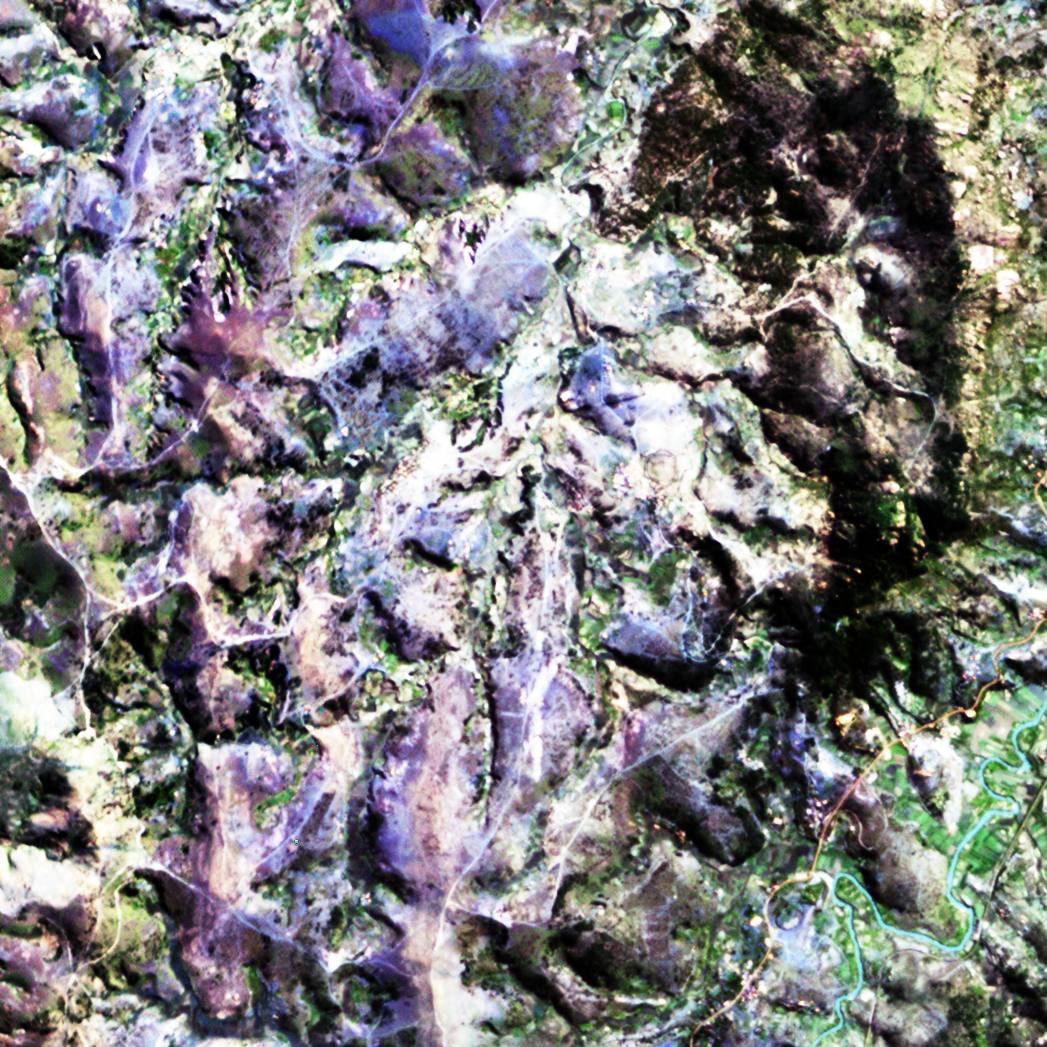

In [ ]:
img = Image.open(Path('/content/drive/.shortcut-targets-by-id/1fSjE_pz3jLTfmv7HsY7kFtivC-1a-c1b/BONDLY/smallsquareclip2.tif'))

img

### Argument input for training

In [ ]:
params = Namespace(
    action='train', 
    batch_size=32, 
    data_path='data', 
    epochs=10, 
    model_path='checkpoints/weights.h5', 
    output_path='output'
)

params.data_path = Path(params.data_path)
params.model_path = Path(params.model_path)
params.output_path = Path(params.output_path)

In [ ]:
if params.action == "train":
    train(params.data_path, params.model_path, params.epochs, params.batch_size)
elif params.action == "test":
    test(params.data_path, params.model_path)
elif params.action == "run":
    run(params.data_path, params.model_path, params.output_path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Generating Samples for aerial: :  10%|█         | 970/9512 [00:09<01:24, 100.98it/s]


KeyboardInterrupt: ignored

### Argument input for testing

In [ ]:
params = Namespace(
    action='test', 
    batch_size=32, 
    data_path='data', 
    epochs=10, 
    model_path='models/weights.h5', 
    output_path='outputs'
)

params.data_path = Path(params.data_path)
params.model_path = Path(params.model_path)
params.output_path = Path(params.output_path)

In [ ]:
#Incase the primary preprocess_dataset() is not called durring training.
preprocess_dataset(params.data_path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Generating Samples for aerial: : 100%|██████████| 9512/9512 [01:21<00:00, 116.24it/s]


generate_samples Done...


Generating Blur data for test: 100%|██████████| 1903/1903 [00:19<00:00, 96.14it/s]

generate_dirty Done...


In [ ]:
if params.action == "train":
    train(params.data_path, params.model_path, params.epochs, params.batch_size)
elif params.action == "test":
    test(params.data_path, params.model_path)
elif params.action == "run":
    run(params.data_path, params.model_path, params.output_path)

Loading test Data:: 100%|██████████| 1903/1903 [00:31<00:00, 59.63it/s]


60/60 [==============================] - 24s 162ms/step - loss: 0.0012 - accuracy: 0.9263
['loss', 'accuracy'] [0.0012096548452973366, 0.9262673854827881]


### Argument input for the final run

In [ ]:
params = Namespace(
    action='run', 
    batch_size=32, 
    data_path='data', #the directory where the input images are
    epochs=10, 
    model_path='models/weights.h5', 
    output_path='outputs'
)

params.data_path = Path(params.data_path)
params.model_path = Path(params.model_path)
params.output_path = Path(params.output_path)

In [ ]:
#Incase the primary preprocess_dataset() is not called durring training.
preprocess_dataset(params.data_path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Generating Samples for aerial: : 100%|██████████| 9512/9512 [01:52<00:00, 84.62it/s]


generate_samples Done...


Generating Blur data for test: 100%|██████████| 1903/1903 [00:24<00:00, 76.43it/s]

generate_dirty Done...


In [ ]:
if params.action == "train":
    train(params.data_path, params.model_path, params.epochs, params.batch_size)
elif params.action == "test":
    test(params.data_path, params.model_path)
elif params.action == "run":
    run(params.data_path/TEST, params.model_path, params.output_path)

100%|██████████| 1903/1903 [02:11<00:00, 14.44it/s]


# Misc. code durring my debugging. (Ignore)

In [ ]:
temp_npy_file = Path(mkdtemp())/'temp_file.npy'
np.save(temp_npy_file,np.array([]))
temp_array = np.memmap(temp_npy_file, dtype='float64', shape=(1, ROWS, COLS, CHANNELS))
img = Image.open('/content/srcnn/data/train_labels/aerial_00000.jpg')
img


In [ ]:
clean_mkdir("checkpoints")
checkpointer = ModelCheckpoint(
    filepath="checkpoints/weights.h5", verbose=1, save_best_only=True
    #filepath="checkpoints/", verbose=1, save_best_only=True
)
model = get_model(params.model_path)
print('Model Loaded...')

Model Loaded...


In [ ]:
train_path = params.data_path / TRAIN
train_labels_path = params.data_path / TRAIN_LABEL
x, y = load_data(train_path, train_labels_path)
print('load_data Done...')

Loading train Data:: 100%|██████████| 7609/7609 [03:36<00:00, 35.15it/s]

load_data Done...


In [ ]:
preprocess_dataset(params.data_path)
print('preprocess_dataset Done...')

clean_mkdir("checkpoints")
checkpointer = ModelCheckpoint(
    filepath="checkpoints/weights.h5", verbose=1, save_best_only=True
    #filepath="checkpoints/", verbose=1, save_best_only=True
)
model = get_model(params.model_path)
print('Model Loaded...')



/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Generating Samples for aerial: : 100%|██████████| 9512/9512 [01:51<00:00, 84.98it/s]


generate_samples Done...


Generating Blur data for test: 100%|██████████| 1903/1903 [00:25<00:00, 75.18it/s]


generate_dirty Done...
preprocess_dataset Done...
Model Loaded...


Loading train Data:: 100%|██████████| 7609/7609 [05:07<00:00, 24.74it/s]

load_data Done...


In [ ]:
model.fit(
    x,
    y,
    batch_size=params.batch_size,
    epochs=params.epochs,
    validation_split=0.2,
    callbacks=[checkpointer],
    shuffle=True,
)


Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.7800 
Epoch 1: val_loss improved from inf to 0.00282, saving model to checkpoints/weights.h5
191/191 [==============================] - 8744s 46s/step - loss: 0.0109 - accuracy: 0.7800 - val_loss: 0.0028 - val_accuracy: 0.8862
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.8901 
Epoch 2: val_loss improved from 0.00282 to 0.00204, saving model to checkpoints/weights.h5
191/191 [==============================] - 8844s 46s/step - loss: 0.0024 - accuracy: 0.8901 - val_loss: 0.0020 - val_accuracy: 0.8943
Epoch 3/10
126/191 [==================>...........] - ETA: 48:39 - loss: 0.0019 - accuracy: 0.8966

In [ ]:
np.asarray(img,dtype="float64")/255.0

In [ ]:
temp_array = np.zeros_like(temp_array)
temp_array

In [ ]:
temp_array[0] = np.asarray(img,dtype="float64")/255.0
temp_array

In [ ]:
temp_array.dtype

dtype('float64')

In [ ]:
    for index, file_ in enumerate(tqdm(x_files, desc=f'Loading {x_path.stem} Data:')):
        img = Image.open(x_path / file_)
        img_array = np.asarray(img, dtype="float64")
        img_array = img_array / 255.0
        x_array[index] = img_array

dtype('float64')

In [ ]:
a

array([[1.668967e-02, 1.259000e+03, 3.400727e-02],
       [2.097502e-02, 6.093085e-02, 3.420668e-02],
       [1.794626e-02, 5.870845e-02, 2.130877e-02]])

In [ ]:
data_path = params.data_path
epochs = params.epochs
batch_size = params.batch_size 
model_path = params.model_path

In [ ]:
preprocess_dataset(data_path)
print('preprocess_dataset Done...')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


generate_samples Done...
generate_dirty Done...
preprocess_dataset Done...


In [ ]:
clean_mkdir("checkpoints")
checkpointer = ModelCheckpoint(
    #filepath="checkpoints/weights.h5", verbose=1, save_best_only=True
    filepath="checkpoints/weights.h5", verbose=1, save_best_only=True
)
model = get_model()
print('Model Loaded...')

Model Loaded...


In [ ]:
train_path = data_path / TRAIN
train_labels_path = data_path / TRAIN_LABEL

x, y = load_data(train_path, train_labels_path)
print('load_data Done...')

7609
load_data Done...


In [ ]:
model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[checkpointer],
    shuffle=True,
)

model.save(model_path)

Epoch 1/10
  4/191 [..............................] - ETA: 2:17:34 - loss: 8.0802e-04 - accuracy: 0.5010

In [ ]:
x_path = Path('data/train')
y_path = Path('data/train_labels')


In [ ]:
x, y = load_data(x_path, y_path)

7609


In [ ]:
x_files = os.listdir(x_path)

x_array = memap_array_init(file_name = 'x_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float64')
y_array = memap_array_init(file_name = 'y_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float64')

In [ ]:
for index, file_ in enumerate(tqdm(x_files, desc=f'Loading {x_path.stem} Data:')):
    img = Image.open(x_path / file_)
    img_array = np.asarray(img, dtype="float64")
    img_array = img_array / 255.0
    x_array[index] = img_array

    if y_path:
        img = Image.open(y_path / file_)
        img_array = np.asarray(img, dtype="float64")
        img_array = img_array / 255.0
        y_array[index] = img_array

#print(y_array,img_array)


Loading train Data:: 100%|██████████| 7609/7609 [04:48<00:00, 26.34it/s]


In [ ]:
return x_array, y_array

In [ ]:
def load_data(x_path, y_path=None):
    x_files = os.listdir(x_path)

    x_array = memap_array_init(file_name = 'x_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float64')
    y_array = memap_array_init(file_name = 'y_file',shape = (len(x_files), ROWS, COLS, CHANNELS), dtype ='float64')

    for index, file_ in enumerate(tqdm(x_files, desc=f'Loading {x_path.stem} Data:')):
        img = Image.open(x_path / file_)
        img_array = np.asarray(img, dtype="float64")
        img_array = img_array / 255.0
        x_array[index] = img_array

        if y_path:
            img = Image.open(y_path / file_)
            img_array = np.asarray(img, dtype="float64")
            img_array = img_array / 255.0
            y_array[index] = img_array

    #print(y_array,img_array)
    return x_array, y_array

In [ ]:
#preprocess_dataset(data_path)
print('preprocess_dataset Done...')

train_path = data_path / TRAIN
train_labels_path = data_path / TRAIN_LABEL
clean_mkdir("checkpoints")
checkpointer = ModelCheckpoint(
    #filepath="checkpoints/weights.h5", verbose=1, save_best_only=True
    filepath="checkpoints/", verbose=1, save_best_only=True
)
model = get_model()
print('Model Loaded...')

x, y = load_data(train_path, train_labels_path)
print('load_data Done...')

model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[checkpointer],
    shuffle=True,
)

model.save(model_path)

In [ ]:
clean_mkdir("checkpoints")
checkpointer = ModelCheckpoint(
    #filepath="checkpoints/weights.h5", verbose=1, save_best_only=True
    filepath="checkpoints/", verbose=1, save_best_only=True
)
model = get_model()

In [ ]:
model.fit(
        x,
        y,
        batch_size=32,
        epochs=2,
        validation_split=0.2,
        callbacks=[checkpointer],
        shuffle=True,
    )

Epoch 1/2
  1/191 [..............................] - ETA: 2:17:52 - loss: 7.5386e-04 - accuracy: 0.0023

KeyboardInterrupt: ignored

In [ ]:
x.shape

(7609, 400, 400, 3)

In [ ]:
xl = os.listdir(x_path)
yl = os.listdir(y_path)

In [ ]:
len(xl)

1903

In [ ]:
x, y = [], []
index = 0
print(len(os.listdir(x_path)))
files = os.listdir(x_path)
for file_ in files[0:6]:
    index += 1
    img = Image.open(x_path / file_)
    img_array = np.asarray(img, dtype="uint8")
    img_array = img_array / (MAX_VAL * 1.0)
    x.append(img_array)

    img = Image.open(y_path / file_)
    img_array = np.asarray(img, dtype="uint8")
    img_array = img_array / (MAX_VAL * 1.0)
    y.append(img_array)

    

7609


In [ ]:
len(xl)

7609

In [ ]:
np.array(x).shape, np.array(y)

((6, 400, 400, 3), array([], dtype=float64))

In [ ]:
def load_data(x_path, y_path=None):
    x, y = [], []
    index = 0
    print(len(os.listdir(x_path)))
    for file_ in os.listdir(x_path):
        index += 1
        img = Image.open(x_path / file_)
        img_array = np.asarray(img, dtype="uint8")
        img_array = img_array / (MAX_VAL * 1.0)
        x.append(img_array)

        if y_path is None:
            img = Image.open(y_path / file_)
            img_array = np.asarray(img, dtype="uint8")
            img_array = img_array / (MAX_VAL * 1.0)
            y.append(img_array)

    return np.array(x), np.array(y)

In [ ]:
import numpy as np

In [ ]:
x = np.memmap('filename.npy', dtype='uint8', shape=(2000, 400, 400, 3))
x.shape

(2000, 400, 400, 3)

In [ ]:
x = np.ones_like(x)

In [ ]:
x

memmap([[[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         ...,

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],

         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]]],


        [[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
     

In [ ]:
3000*400*400*3*8/1000000000

11.52

In [ ]:
`7609*400*400*3

3652320000

In [ ]:









if __name__ == "__main__":
    
    

    



/content/srcnn


In [ ]:
!pwd

/content/srcnn


In [ ]:
!python srcnn.py --action train --data_path data

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (101832000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
Traceback (most recent call last):
  File "srcnn.py", line 96, in <module>
    train(params.data_path, params.epochs, params.batch_size, params.model_path)
  File "srcnn.py", line 14, in train
    preprocess_dataset(data_path)
  File "/content/srcnn/preprocess.py", line 106, in preprocess_dataset
    generate_samples(str(images_path / filename), data_path)
  File "/content/srcnn/preprocess.py", line 30, in generate_samples
    for i in range(0, cols - COLS - 1, COLS / 2):
TypeError: 'float' object cannot be interpreted as an integer


In [ ]:
!python srcnn.py --action test --data_path data --model_path models/weights2.h5

2022-06-15 12:02:51.517730: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Traceback (most recent call last):
  File "srcnn.py", line 91, in <module>
    test(Path(params.data_path), Path(params.model_path))
  File "srcnn.py", line 39, in test
    x, y = load_data(test_path, test_labels_path)
  File "/content/srcnn/util.py", line 28, in load_data
    for file in os.listdir(x_path):
FileNotFoundError: [Errno 2] No such file or directory: 'data/test'


In [ ]:
PurePath('/content/srcnn/data/images/aerial.jpg').stem

'aerial'